# <center>Support Vector Machines</center>
---

In this notebook, you will use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data are transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

In [19]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt

###  Load the Cancer data
---
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

For the purposes of this example, we're using a dataset that has a relatively small number of predictors in each record. To download the data, we will use `!wget` to download it from IBM Object Storage.  
__Did you know?__ When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)

In [20]:
#Click here and press Shift+Enter
#!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

### Load Data From CSV File  
---

In [21]:
#Mount google colab agar file bisa terbaca
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
abalone_df = pd.read_csv("/content/drive/My Drive/Pertemuan 11/3. Klasifikasi/abalone.csv")
abalone_df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,3,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

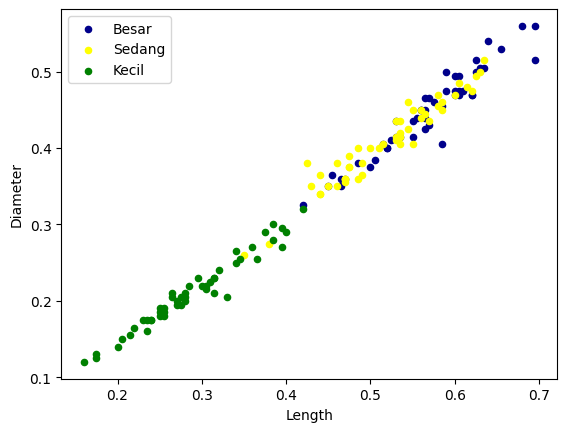

In [23]:
ax = abalone_df[abalone_df['Rings'] == 15][0:50].plot(kind='scatter', x='Length', y='Diameter', color='DarkBlue', label='Besar');
abalone_df[abalone_df['Rings'] == 10][0:50].plot(kind='scatter', x='Length', y='Diameter', color='Yellow', label='Sedang', ax=ax);
abalone_df[abalone_df['Rings'] == 5][0:50].plot(kind='scatter', x='Length', y='Diameter', color='Green', label='Kecil', ax=ax);

plt.show()

## Data pre-processing and selection
---

Lets first look at columns data types:

In [24]:
abalone_df.dtypes

,0
Sex,int64
Length,float64
Diameter,float64
Height,float64
Whole_weight,float64
Shucked_weight,float64
Viscera_weight,float64
Shell_weight,float64
Rings,int64


It looks like the __BareNuc__ column includes some values that are not numerical. We can drop those rows:

In [25]:
feature_df = abalone_df[['Sex', 'Length' ,'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']]
X = np.asarray(feature_df)
X[0:5]

array([[ 1.  ,  0.46,  0.36,  0.1 ,  0.51,  0.22,  0.1 ,  0.15, 15.  ],
       [ 1.  ,  0.35,  0.27,  0.09,  0.23,  0.1 ,  0.05,  0.07,  7.  ],
       [ 2.  ,  0.53,  0.42,  0.14,  0.68,  0.26,  0.14,  0.21,  9.  ],
       [ 1.  ,  0.44,  0.36,  0.12,  0.52,  0.22,  0.11,  0.15, 10.  ],
       [ 3.  ,  0.33,  0.26,  0.08,  0.2 ,  0.09,  0.04,  0.06,  7.  ]])

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [26]:
abalone_df['Rings'] = abalone_df['Rings'].astype('int')
y = np.asarray(abalone_df['Rings'])
y [0:5]

array([15,  7,  9, 10,  7])

## Train/Test dataset
---

Okay, we split our dataset into train and test set:

In [27]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3341, 9) (3341,)
Test set: (836, 9) (836,)


# Modeling (SVM with Scikit-learn)
---

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

After being fitted, the model can then be used to predict new values:

In [28]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', gamma='auto')
clf.fit(X_train, y_train)

SVC(gamma='auto')

In [29]:
yhat = clf.predict(X_test)
yhat [0:5]

array([ 8, 10,  8, 12,  6])

## Evaluation
---

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.33      1.00      0.50         1
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        47
           7       1.00      1.00      1.00        70
           8       1.00      1.00      1.00       133
           9       1.00      1.00      1.00       137
          10       1.00      1.00      1.00       142
          11       1.00      1.00      1.00        91
          12       1.00      1.00      1.00        53
          13       1.00      1.00      1.00        46
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        23
          16       1.00      1.00      1.00        10
          17       1.00      1.00      1.00         8
          18       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


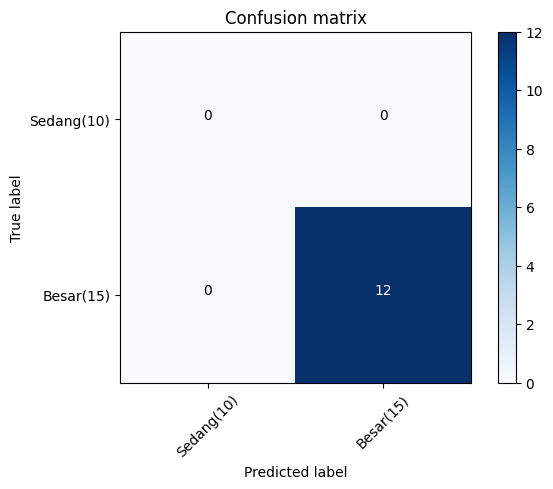

In [32]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Sedang(10)','Besar(15)'],normalize= False,  title='Confusion matrix')

You can also easily use the __f1_score__ fron sklearn library:

In [33]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.9953007518796992

Lets try jaccard index for accuracy:

In [34]:
#from sklearn.metrics import jaccard_similarity_score
#jaccard_similarity_score(y_test, yhat)
#jaccard_score(y_test, yhat, average=None)


from sklearn.metrics import jaccard_score

jaccard_score(y_test, yhat, average='macro')


0.8297101449275361